In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

# This notebook seeks to use all OPV processing conditions and morphological descriptors to predict device performance. 

## This third NN is an ensemble of two others, with an aggregation of their results. will further incorporate morphological information. The morphological descriptors (by domain) and/or the actual label maps will provide local information for the bulk-averaged device metrics.

### Inputs:
- DataFrame containing device processing conditions and their subsequent performance. This will similarly only include good devices

- DataFrame containing morphology descriptors by domain within the active-layer

- Semantic and Instance segmentation labels produced by the m2py framework

### Outputs:
- Tensor of predicted performance for given processing conditions

# Take in device data as a pd.DataFrame for embedding

In [2]:
device_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/OPV_total_df.xlsx')
print (device_df.shape)
device_df.head()

(108, 20)


,Unnamed: 0,Anneal_time,Anneal_temp,Substrate,Device,MajorAL_avg,MajorAL_stdev,MinorAL_avg,MinorAL_stdev,Ecc_avg,Ecc_stdev,Orient_avg,Orient_stdev,Perim_avg,Perim_stdev,GMM_label,PCE,VocL,Jsc,FF
0,0,15,100,4,2,17.194652,29.172066,8.554721,14.246681,0.820518,0.142370,-0.050137,1.067225,97.003245,352.677591,1,2.311387,0.577792,6.963861,57.44484
1,1,15,100,4,4,13.709728,14.635628,6.938374,7.985216,0.824877,0.138410,-0.205623,1.075388,48.559552,98.492589,1,1.763230,0.522596,7.047848,47.87256
2,2,15,100,4,7,18.211098,21.013541,8.857453,10.356933,0.826205,0.148190,-0.414390,1.047842,75.736366,151.456627,1,2.394418,0.575790,6.939877,59.92170
3,3,30,100,7,2,19.640309,46.935628,9.781374,26.994708,0.857443,0.105577,-0.331902,0.940640,236.482362,1306.085256,1,2.628197,0.569525,7.301575,63.20169
4,4,30,100,7,4,20.647291,35.791550,8.412561,11.216702,0.833485,0.136928,-0.454930,0.862964,96.093361,315.148913,1,2.710602,0.568631,7.328048,65.04993


# Take in image data as a np.ndarray for embedding

In [ ]:
im_directory = '/Volumes/SSD-1/Grad School/m2py/......./'

im_filepaths = os.listdir(im_directory)

image_dict = {} # Hold all the image-like data
im_labels = {} # Gather all the processing conditions to be the predicted feature

for i,fl in enumerate(im_filepaths):
    image_dict[i] = np.load(im_directory+fl)
    
    anl_temp = 0
    anl_time = 0
    
    if 'NOANNEAL' in fl:
        pass
    
    else:
        temp_stop_indx = fl.index('C')
        anl_temp = int(fl[:temp_stop_indx])


        time_start_indx = temp_stop_indx+2
        time_stop_indx = fl.index('m')
        time_stop_indx = time_stop_indx
        anl_time = fl[time_start_indx:time_stop_indx]
        anl_time = int(anl_time)
        
    im_labels[i] = [anl_temp, anl_time]
    
im_labels_df = pd.fromDict(im_labels)
    
print (image_dict.shape)
im_labels.head()

In [3]:
X_im = image_dict #input features used to make prediction
Y_im = im_labels_df #target features to be predicted

x_im_train, x_im_test, y_im_train, y_im_test = train_test_split(X_im,Y_im, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

In [ ]:
# Hyper parameters
num_epochs = 10
im_batch_size = int(len(x_train[0])*0.9) # 90% of x_train samples
df_batch_size = int(len(x_train[0])*0.9) # 90% of x_train samples
im_learning_rate = 0.008
df_learning_rate = 0.001

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
x_im_train_tensor = torch.tensor(x_im_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
y_im_train_tensor = torch.tensor(y_im_train.values.astype(np.float32))
im_train_tensor = torch.utils.data.TensorDataset(x_im_train_tensor, y_im_train_tensor) #create tensor with features and targets
im_training_data_set = torch.utils.data.DataLoader(dataset = im_train_tensor, batch_size = im_batch_size, shuffle = True) #create iterable dataset with batches

x_im_test_tensor = torch.tensor(x_im_test.values.astype(np.float32))
y_im_test_tensor = torch.tensor(y_test.values.astype(np.float32))
im_test_tensor = torch.utils.data.TensorDataset(x_im_test_tensor, y_im_test_tensor)
im_testing_data_set = torch.utils.data.DataLoader(dataset = im_test_tensor, batch_size = im_batch_size, shuffle = True)

In [ ]:
im_x, im_y, im_z = x_im[0].shape

In [ ]:
X_df = total_df[['Anneal_time', 'Anneal_temp', 'MajorAL_avg', 'MajorAL_stdev', 'MinorAL_avg',
              'MinorAL_stdev', 'Ecc_avg', 'Ecc_stdev', 'Orient_avg', 'Orient_stdev', 'Perim_avg',
              'Perim_stdev', 'GMM_label']] #input features used to make prediction
Y_df = total_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_df_train, x_df_test, y_df_train, y_df_test = train_test_split(X_df,Y_df, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

x_df_train_tensor = torch.tensor(x_df_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
y_df_train_tensor = torch.tensor(y_df_train.values.astype(np.float32))
df_train_tensor = torch.utils.data.TensorDataset(x_df_train_tensor, y_df_train_tensor) #create tensor with features and targets
df_training_data_set = torch.utils.data.DataLoader(dataset = df_train_tensor, batch_size = df_batch_size, shuffle = True) #create iterable dataset with batches

x_df_test_tensor = torch.tensor(x_df_test.values.astype(np.float32))
y_df_test_tensor = torch.tensor(y_test.values.astype(np.float32))
df_test_tensor = torch.utils.data.TensorDataset(x_df_test_tensor, yv_test_tensor)
df_testing_data_set = torch.utils.data.DataLoader(df_dataset = test_tensor, batch_size = df_batch_size, shuffle = True)

In [ ]:
class ImBranchNN(nn.Module):
    
    def __init__(self, im_x, im_y, im_z):
        super(ImBranchNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2D(im_z, 32, kernal_size = 8, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2D(kernal_size = 2, stride = 2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2D(32, 64, kernal_size = 5, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2D(kernal_size = 2, stride = 2)
        )
            
            
        fc_nodes = (im_x/4) * (im_y/4) * 64 # 4 because there were 2 maxpool layers with 2x2 Kernals,
                                            # reducing the overall channel width & height by half each time
        
        self.layer3 = nn.Sequential(
            nn.dropout(),               #helps avoid over-fitting
            nn.Linear(fc_nodes, 10000), #Final kernal-size * im_x * im_y
            nn.Linear(10000, 5000),
            nn.Linear(5000, 1000),
            nn.Linear(1000, 100)
        )
        
        self.out_layer = nn.Linear(100, 2) #predicting anneal time and temp
            
    def forward(self, x_im):
        im_out = self.layer1(x_im)
        im_out = self.layer2(im_out)
        im_out = self.layer3(im_out)
        im_train_out = self.out_layer(im_out)
        
        return im_out, im_train_out

In [ ]:
def DfBranchNN(nn.Module):
    
    def __init__(self, in_dims, out_dims):
        super(DfBranchNN, self).__init__()
        
        self.df_layer1 = nn.Sequential(
            #embedding layer
            self.em_layer = nn.Linear(in_dims, out_dims)

            #hidden layers
            self.h_layer1 = nn.Linear(out_dims, 32)
            self.h_layer2 = nn.Linear(32, 16)
            self.h_layer3 = nn.Linear(16, 8)
        )

        #output layers
        self.PCE_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        self.Voc_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        self.Jsc_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        self.FF_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        
        def forward(self, x_df):
            df_out = self.df_layer1(x_df)
            pce_out = self.PCE_branch(df_out)
            voc_out = self.Voc_branch(df_out)
            jsc_out = self.Jsc_branch(df_out)
            ff_out = self.FF_branch(df_out)
            
            return pce_out, voc_out, jsc_out, ff_out

In [5]:
#define the neural network
class NN3(nn.Module):
    
    def __init__(self, im_branch_model, df_branch_model, im_x, im_y, im_z, in_dims, out_dims):
        super(NN1, self).__init__()
        
        self.im_branch = im_branch_model(im_x, im_y, im_z)
        
        self.df_branch = df_branch_model(in_dims, out_dims)
        
        #Aggregation and compression layers
        self.final_pce_branch = nn.Sequential(
            nn.Linear(101, 256)
            nn.Linear(256, 64)
            nn.Linear(64, 1)
        )
        
        self.final_voc_branch = nn.Sequential(
            nn.Linear(101, 256)
            nn.Linear(256, 64)
            nn.Linear(64, 1)
        )
        
        self.final_jsc_branch = nn.Sequential(
            nn.Linear(101, 256)
            nn.Linear(256, 64)
            nn.Linear(64, 1)
        )
        
        self.final_ff_branch = nn.Sequential(
            nn.Linear(101, 256)
            nn.Linear(256, 64)
            nn.Linear(64, 1)
        )
        
        
    def forward(self, x_im, x_df):
        
        #Image branch. Only use 100-D tensor of morphology info for final output
        im_out, im_train_out = self.im_branch(x_im)
        
        #DataFrame branch
        pce_out, voc_out, jsc_out, ff_out = self.df_branch(x_df)
        
        #Combine outputs from the two branches
        total_pce_out = torch.cat((im_out, pce_out), dim = 1)
        total_voc_out = torch.cat((im_out, voc_out), dim = 1)
        total_jsc_out = torch.cat((im_out, jsc_out), dim = 1)
        total_ff_out = torch.cat((im_out, ff_out), dim = 1)
        
        #Aggregation and output layers
        total_pce_out = self.final_pce_branch(total_pce_out)
        total_voc_out = self.final_voc_branch(total_voc_out)
        total_jsc_out = self.final_jsc_branch(total_jsc_out)
        total_ff_out = self.final_ff_branch(total_ff_out)
        
        return total_pce_out, total_voc_out, total_jsc_out, total_ff_out, im_out, im_train_out pce_out, voc_out, jsc_out, ff_out

In [ ]:
def train_im_branch_one_epoch(model, im_training_data_set, im_criterion):
    total_step = len(im_training_data_set)
    loss_list = []
    
    model.train()
    
#     #freeze other layers
#     model.df_branch.weight.requires_grad = False
#     model.df_branch.bias.requires_grad = False
#     model.final_pce_branch.weight.requires_grad = False
#     model.final_pce_branch.bias.requires_grad = False
#     model.final_voc_branch.weight.requires_grad = False
#     model.final_voc_branch.bias.requires_grad = False
#     model.final_jsc_branch.weight.requires_grad = False
#     model.final_jsc_branch.bias.requires_grad = False
#     model.final_ff_branch.weight.requires_grad = False
#     model.final_ff_branch.bias.requires_grad = False
    
    for images, labels in im_training_data_set:
        # Run the forward pass
        im_out, im_train_out = model(images)
        optimizer.zero_grad()
        
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=im_learning_rate)
        
        # Gather the loss
        loss = im_criterion(outputs, labels)
        loss_list.append(loss.item())

        # backprop and perform Adam optimization
        torch.autograd.backward(loss)
        optimizer.step()
        
#     #unfreeze other layers
#     model.df_branch.weight.requires_grad = True
#     model.df_branch.bias.requires_grad = True
#     model.final_pce_branch.weight.requires_grad = True
#     model.final_pce_branch.bias.requires_grad = True
#     model.final_voc_branch.weight.requires_grad = True
#     model.final_voc_branch.bias.requires_grad = True
#     model.final_jsc_branch.weight.requires_grad = True
#     model.final_jsc_branch.bias.requires_grad = True
#     model.final_ff_branch.weight.requires_grad = True
#     model.final_ff_branch.bias.requires_grad = True
    
#     #Add the previously frozen weights to the optimizer
#     optimizer.add_param_group({'params': [model.df_branch.parameters(), model.final_pce_branch.parameters(),
#                                               model.final_voc_branch.parameters(), model.final_jsc_branch.parameters(),
#                                               model.final_ff_branch.parameters()]})
    
    total = len(loss_list)
    epoch_loss = sum(loss_list)/total
    
    return epoch_loss

In [ ]:
def train_df_branch_one_epoch(model, df_training_data_set, df_criterion):
    
    model.train()
    
#     #freeze other layers
#     model.im_branch.weight.requires_grad = False
#     model.im_branch.bias.requires_grad = False
#     model.final_pce_branch.weight.requires_grad = False
#     model.final_pce_branch.bias.requires_grad = False
#     model.final_voc_branch.weight.requires_grad = False
#     model.final_voc_branch.bias.requires_grad = False
#     model.final_jsc_branch.weight.requires_grad = False
#     model.final_jsc_branch.bias.requires_grad = False
#     model.final_ff_branch.weight.requires_grad = False
#     model.final_ff_branch.bias.requires_grad = False
    
    train_epoch_loss = []
    pce_train_epoch_loss = []
    voc_train_epoch_loss = []
    jsc_train_epoch_loss = []
    ff_train_epoch_loss = []
    
    train_losses = []
    pce_train_losses = []
    voc_train_losses = []
    jsc_train_losses = []
    ff_train_losses = []
    
    pce_criterion = PhysLoss.ThresholdedMSELoss(lower = 0, upper = 6)
    voc_criterion = PhysLoss.ThresholdedMSELoss(lower = 0, upper = 1)
    jsc_criterion = PhysLoss.ThresholdedMSELoss(lower = 0, upper = 10)
    ff_criterion = PhysLoss.ThresholdedMSELoss(lower = 10, upper = 85)
    
    train_total = 0
    
    for train_data, pce_labels, voc_labels, jsc_labels, ff_labels in df_training_data_set:
        
        train_data = train_data.to(device)
        pce_labels = pce_labels.to(device)
        voc_labels = voc_labels.to(device)
        jsc_labels = jsc_labels.to(device)
        ff_labels = ff_labels.to(device)
        
        model.zero_grad()
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=im_learning_rate)
        
        PCE_out, Voc_out, Jsc_out, FF_out = model(train_data)
        
        #calculate error in the predictions
        pce_loss = pce_criterion(PCE_out, pce_labels)
        voc_loss = voc_criterion(Voc_out, voc_labels)
        jsc_loss = jsc_criterion(Jsc_out, jsc_labels)
        ff_loss = ff_criterion(FF_out, ff_labels)
        
        total_loss = pce_loss + voc_loss + jsc_loss + ff_loss
        
        #BACKPROPOGATE LIKE A MF
        torch.autograd.backward([pce_loss, voc_loss, jsc_loss, ff_loss])
        optimizer.step()
        
        #save loss for this batch
        train_losses.append(total_loss.item())
        train_total+=1
        
        pce_train_losses.append(pce_loss.item())
        voc_train_losses.append(voc_loss.item())
        jsc_train_losses.append(jsc_loss.item())
        ff_train_losses.append(ff_loss.item())
        
    #calculate and save total error for this epoch of training
    epoch_loss = sum(train_losses)/train_total
    train_epoch_loss.append(epoch_loss)
    
    pce_train_epoch_loss.append(sum(pce_train_losses)/train_total)
    voc_train_epoch_loss.append(sum(voc_train_losses)/train_total)
    jsc_train_epoch_loss.append(sum(jsc_train_losses)/train_total)
    ff_train_epoch_loss.append(sum(ff_train_losses)/train_total)
    
    #update progress output
    print(f"Total Epoch Training Loss = {train_epoch_loss}")
    
#     #unfreeze other layers
#     model.im_branch.weight.requires_grad = True
#     model.im_branch.bias.requires_grad = True
#     model.final_pce_branch.weight.requires_grad = True
#     model.final_pce_branch.bias.requires_grad = True
#     model.final_voc_branch.weight.requires_grad = True
#     model.final_voc_branch.bias.requires_grad = True
#     model.final_jsc_branch.weight.requires_grad = True
#     model.final_jsc_branch.bias.requires_grad = True
#     model.final_ff_branch.weight.requires_grad = True
#     model.final_ff_branch.bias.requires_grad = True
    
#     #Add the previously frozen weights to the optimizer
#     optimizer.add_param_group({'params': [model.im_branch.parameters(), model.final_pce_branch.parameters(),
#                                               model.final_voc_branch.parameters(), model.final_jsc_branch.parameters(),
#                                               model.final_ff_branch.parameters()]})
    
    return train_epoch_loss, pce_train_epoch_loss, voc_train_epoch_loss, jsc_train_epoch_loss, ff_train_epoch_loss

In [ ]:
def train_ensemble_one_epoch(model, x_im, x_df, final_criterion):
    
    model.train()
    
    #freeze other layers
    model.im_branch.weight.requires_grad = False
    model.im_branch.bias.requires_grad = False
    model.df_branch.weight.requires_grad = False
    model.df_branch.bias.requires_grad = False
    
    for i in range(total_step):
        # Run the forward pass
        PCE_out, Voc_out, Jsc_out, FF_out = model(x_im, x_df)
        optimizer.zero_grad()
        
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=final_learning_rate)
        
        # Gather the loss
        pce_loss = pce_criterion(PCE_out, pce_labels)
        voc_loss = voc_criterion(Voc_out, voc_labels)
        jsc_loss = jsc_criterion(Jsc_out, jsc_labels)
        ff_loss = ff_criterion(FF_out, ff_labels)
        
        # Clear previous gradients, backprop and perform Adam optimization
        torch.autograd.backward([pce_loss, voc_loss, jsc_loss, ff_loss])
        optimizer.step()
        
        pce_train_losses.append(pce_loss.item())
        voc_train_losses.append(voc_loss.item())
        jsc_train_losses.append(jsc_loss.item())
        ff_train_losses.append(ff_loss.item())
    
    #unfreeze other layers
    model.im_branch.weight.requires_grad = True
    model.im_branch.bias.requires_grad = True
    model.df_branch.weight.requires_grad = True
    model.df_branch.bias.requires_grad = True
    
    #Add the previously frozen weights to the optimizer
    optimizer.add_param_group({'params': [model.im_branch.parameters(), model.df_branch.parameters()]})
    
    return loss_list

In [7]:
def eval_model(model, testing_data_set, criterion, optimizer):
    #evaluate the model
    model.eval()

    #don't update nodes during evaluation b/c not training
    with torch.no_grad():
        test_losses = []
        test_total = 0

        for inputs, labels in testing_data_set:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
    
            # calculate loss per batch of testing data
            test_loss = criterion(outputs, labels)
            test_losses.append(test_loss.item())
            test_total += 1

        total_test_loss = sum(test_losses)/test_total

        print (f"Total testing loss is: {total_test_loss}")
    return total_test_loss

In [ ]:
def eval_im_branch():

In [ ]:
def eval_df_branch():

In [ ]:
def eval_final_branch():

Now that the data, model, training, and evaluating are all set up, let's actually use everything

In [ ]:
im_x, im_y, im_z = image_dict.shape()
print (image_dict.shape())

# predicts 4 metrics (PCE, Voc, Jsc, FF)
in_dims = int(x_train_tensor.size(1)) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

# takes in 2 models, 2 label map dimensions, dataframe features
im_branch_model = ImBranchNN(im_x, im_y, im_z)
df_branch_model = DFBranchNN(in_dims, out_dims)


#define the loss function and the optimizer
im_criterion = nn.CrossEntropyLoss()
im_optimizer = torch.optim.Adam(model.parameters(), lr = im_learning_rate)

df_criterion = nn.MSELoss(reduction = 'mean')
df_optimizer = torch.optim.Adam(params = model.parameters(), lr = df_learning_rate)



In [ ]:
#empty list to hold loss per epoch
im_train_epoch_losses = []
im_test_epoch_losses = []
df_train_epoch_losses = []
df_test_epoch_losses = []

In [ ]:
for epoch in range(num_epochs):
    
    # First Train the image branch
    im_train_epoch_loss = train_im_branch_one_epoch(model = im_branch_model,
                                   training_data_set = im_training_data_set,
                                   criterion = im_criterion,
                                   optimizer = im_optimizer)
    
    im_train_epoch_losses.append(im_train_epoch_loss)
    
    im_test_epoch_loss = eval_im_branch(model = im_branch_model,
                                 testing_data_set = im_testing_data_set,
                                 criterion = im_criterion,
                                 optimizer = im_optimizer)
    
    im_test_epoch_losses.append(im_test_epoch_loss)
    
    # Then Train the dataframe branch
    df_train_epoch_loss = train_df_branch_one_epoch(model = df_branch_model,
                                   training_data_set = df_training_data_set,
                                   criterion = df_criterion,
                                   optimizer = df_optimizer)
    
    df_train_epoch_losses.append(df_train_epoch_loss)
    
    df_test_epoch_loss = eval_df_branch(model = df_branch_model,
                                 testing_data_set = df_testing_data_set,
                                 criterion = df_criterion,
                                 optimizer = df_optimizer)
    
    df_test_epoch_losses.append(df_test_epoch_loss)

In [ ]:
# save the trained branch model states

In [ ]:
#load the states of the trained branches
im_branch = ImBranchNN(im_x, im_y, im_z)
df_branch = DFBranchNN(in_dims, out_dims)

modelA.load_state_dict(torch.load(PATH))
modelB.load_state_dict(torch.load(PATH))

model = NN3(im_branch, df_branch, im_x, im_y, im_z,in_dims = in_dims, out_dims = out_dims).to(device)

final_criterion = nn.MSELoss(reduction = 'mean')
final_optimizer = torch.optim.Adam(params = model.parameters(), lr = final_learning_rate)

In [9]:
#empty list to hold loss per epoch
final_train_epoch_losses = []
final_test_epoch_losses = []


for epoch in range(num_epochs):

    # Train the ensemble network of the branch
    final_train_epoch_loss = train_final_branch_one_epoch(model = model,
                                   training_data_set = final_training_data_set,
                                   criterion = final_criterion,
                                   optimizer = final_optimizer)
    
    final_train_epoch_losses.append(final_train_epoch_loss)
    
    final_test_epoch_loss = eval_final_branch(model = model,
                                 testing_data_set = final_testing_data_set,
                                 criterion = final_criterion,
                                 optimizer = final_optimizer)
    
    final_test_epoch_losses.append(final_test_epoch_loss)


Epoch #1	Train Loss: 220.278
Total testing loss is: 135.49010848999023



Epoch #2	Train Loss: 127.618
Total testing loss is: 87.39285278320312



Epoch #3	Train Loss: 93.634
Total testing loss is: 104.9712028503418



Epoch #4	Train Loss: 93.897
Total testing loss is: 90.86677551269531



Epoch #5	Train Loss: 90.259
Total testing loss is: 102.85666275024414



Epoch #6	Train Loss: 87.791
Total testing loss is: 86.30208587646484



Epoch #7	Train Loss: 84.913
Total testing loss is: 95.08184814453125



Epoch #8	Train Loss: 81.852
Total testing loss is: 86.94995498657227



Epoch #9	Train Loss: 81.472
Total testing loss is: 77.79970359802246



Epoch #10	Train Loss: 80.658
Total testing loss is: 85.96835327148438



Epoch #11	Train Loss: 79.511
Total testing loss is: 82.94087982177734



Epoch #12	Train Loss: 80.455
Total testing loss is: 85.11249923706055



Epoch #13	Train Loss: 81.419
Total testing loss is: 93.26236724853516



Epoch #14	Train Loss: 79.661
Total testing loss is: 92.95965194702148



Epoch #15	Train Loss: 79.597
Total testing loss is: 78.95597839355469



Epoch #16	Train Loss: 80.208
Total testing loss is: 90.13513565063477



Epoch #17	Train Loss: 79.465
Total testing loss is: 82.67920303344727



Epoch #18	Train Loss: 80.877
Total testing loss is: 94.0641098022461



Epoch #19	Train Loss: 76.733
Total testing loss is: 75.98038482666016



Epoch #20	Train Loss: 78.287
Total testing loss is: 73.81434440612793



Epoch #21	Train Loss: 75.162
Total testing loss is: 74.93417358398438



Epoch #22	Train Loss: 74.560
Total testing loss is: 81.36275100708008



Epoch #23	Train Loss: 73.545
Total testing loss is: 71.53865242004395



Epoch #24	Train Loss: 75.431
Total testing loss is: 72.4780158996582



Epoch #25	Train Loss: 77.581
Total testing loss is: 74.4681625366211



Epoch #26	Train Loss: 82.681
Total testing loss is: 121.17367553710938



Epoch #27	Train Loss: 88.132
Total testing loss is: 77.72806167602539



Epoch #28	Train Loss: 80.439
Total testing loss is: 68.01948356628418



Epoch #29	Train Loss: 74.549
Total testing loss is: 80.80332946777344



Epoch #30	Train Loss: 72.509
Total testing loss is: 68.02120590209961



Epoch #31	Train Loss: 70.033
Total testing loss is: 66.8721981048584



Epoch #32	Train Loss: 70.495
Total testing loss is: 75.55580139160156



Epoch #33	Train Loss: 70.580
Total testing loss is: 66.92286682128906



Epoch #34	Train Loss: 68.089
Total testing loss is: 65.88185691833496



Epoch #35	Train Loss: 65.826
Total testing loss is: 66.90669441223145



Epoch #36	Train Loss: 64.831
Total testing loss is: 56.71883201599121



Epoch #37	Train Loss: 64.809
Total testing loss is: 59.10163497924805



Epoch #38	Train Loss: 68.642
Total testing loss is: 54.12222099304199



Epoch #39	Train Loss: 64.274
Total testing loss is: 55.40235710144043



Epoch #40	Train Loss: 62.015
Total testing loss is: 50.02823448181152



Epoch #41	Train Loss: 57.660
Total testing loss is: 43.92824649810791



Epoch #42	Train Loss: 59.388
Total testing loss is: 50.26883125305176



Epoch #43	Train Loss: 55.806
Total testing loss is: 47.72796630859375



Epoch #44	Train Loss: 58.348
Total testing loss is: 54.38881874084473



Epoch #45	Train Loss: 64.055
Total testing loss is: 48.427303314208984



Epoch #46	Train Loss: 52.208
Total testing loss is: 54.08432197570801



Epoch #47	Train Loss: 58.128
Total testing loss is: 51.59466361999512



Epoch #48	Train Loss: 51.141
Total testing loss is: 36.80395793914795



Epoch #49	Train Loss: 50.248
Total testing loss is: 40.6252384185791



Epoch #50	Train Loss: 47.606
Total testing loss is: 30.425909996032715



Epoch #51	Train Loss: 51.218
Total testing loss is: 49.57460594177246



Epoch #52	Train Loss: 59.682
Total testing loss is: 31.02025604248047



Epoch #53	Train Loss: 50.130
Total testing loss is: 29.163331031799316



Epoch #54	Train Loss: 44.606
Total testing loss is: 50.53289985656738



Epoch #55	Train Loss: 50.734
Total testing loss is: 78.10733032226562



Epoch #56	Train Loss: 51.929
Total testing loss is: 42.56583786010742



Epoch #57	Train Loss: 44.981
Total testing loss is: 26.636435508728027



Epoch #58	Train Loss: 35.070
Total testing loss is: 25.265433311462402



Epoch #59	Train Loss: 37.243
Total testing loss is: 36.013898849487305



Epoch #60	Train Loss: 46.234
Total testing loss is: 22.560288429260254



Epoch #61	Train Loss: 39.015
Total testing loss is: 18.94016170501709



Epoch #62	Train Loss: 36.162
Total testing loss is: 18.957134246826172



Epoch #63	Train Loss: 37.637
Total testing loss is: 34.42059516906738



Epoch #64	Train Loss: 32.314
Total testing loss is: 24.39774227142334



Epoch #65	Train Loss: 30.188
Total testing loss is: 25.54328441619873



Epoch #66	Train Loss: 28.299
Total testing loss is: 19.648972511291504



Epoch #67	Train Loss: 26.590
Total testing loss is: 24.45563793182373



Epoch #68	Train Loss: 25.870
Total testing loss is: 22.20273208618164



Epoch #69	Train Loss: 27.000
Total testing loss is: 18.050549030303955



Epoch #70	Train Loss: 31.942
Total testing loss is: 15.945837020874023



Epoch #71	Train Loss: 36.063
Total testing loss is: 21.161850929260254



Epoch #72	Train Loss: 31.243
Total testing loss is: 16.02397060394287



Epoch #73	Train Loss: 25.542
Total testing loss is: 15.373791217803955



Epoch #74	Train Loss: 27.528
Total testing loss is: 15.756668090820312



Epoch #75	Train Loss: 25.719
Total testing loss is: 16.432310104370117



Epoch #76	Train Loss: 24.470
Total testing loss is: 22.946829795837402



Epoch #77	Train Loss: 26.587
Total testing loss is: 15.505367279052734



Epoch #78	Train Loss: 26.274
Total testing loss is: 20.581278800964355



Epoch #79	Train Loss: 26.917
Total testing loss is: 19.826366424560547



Epoch #80	Train Loss: 26.348
Total testing loss is: 18.322579383850098



Epoch #81	Train Loss: 26.951
Total testing loss is: 14.070729494094849



Epoch #82	Train Loss: 26.844
Total testing loss is: 18.98857021331787



Epoch #83	Train Loss: 28.340
Total testing loss is: 15.230469703674316



Epoch #84	Train Loss: 25.786
Total testing loss is: 15.196392059326172



Epoch #85	Train Loss: 27.675
Total testing loss is: 20.253599166870117



Epoch #86	Train Loss: 25.950
Total testing loss is: 23.326775550842285



Epoch #87	Train Loss: 25.331
Total testing loss is: 17.606013774871826



Epoch #88	Train Loss: 25.835
Total testing loss is: 16.6996111869812



Epoch #89	Train Loss: 26.275
Total testing loss is: 17.742548942565918



Epoch #90	Train Loss: 25.683
Total testing loss is: 16.744746685028076



Epoch #91	Train Loss: 25.444
Total testing loss is: 20.855467796325684



Epoch #92	Train Loss: 26.245
Total testing loss is: 22.027859687805176



Epoch #93	Train Loss: 26.477
Total testing loss is: 20.793725967407227



Epoch #94	Train Loss: 26.250
Total testing loss is: 15.907047748565674



Epoch #95	Train Loss: 28.386
Total testing loss is: 16.423201084136963



Epoch #96	Train Loss: 26.271
Total testing loss is: 16.38532066345215



Epoch #97	Train Loss: 25.610
Total testing loss is: 15.960204124450684



Epoch #98	Train Loss: 27.570
Total testing loss is: 18.958552360534668



Epoch #99	Train Loss: 29.576
Total testing loss is: 24.35873031616211



Epoch #100	Train Loss: 28.717
Total testing loss is: 30.840493202209473


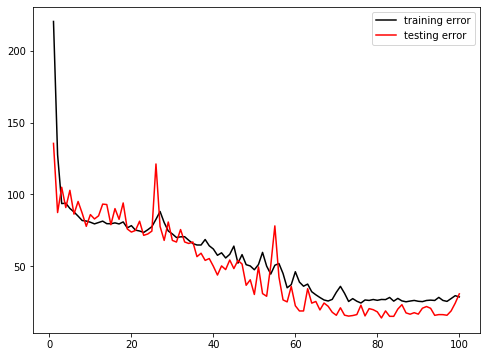

In [10]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.show()